# Loop 2 Analysis: Strategic Assessment

## Current Status
- Best CV: 70.659493 (exp_001 - rebuild_from_corners)
- Best LB: 70.659958 (exp_000 - baseline)
- Target: 68.919154
- Gap: 1.74 points (2.5%)

## Key Questions
1. What is the per-N score distribution? Where is the most room for improvement?
2. What techniques haven't been tried yet?
3. Can we run the eazy-optimizer C++ code?

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 25

print('Libraries loaded')

Libraries loaded


In [2]:
# Load current best solution
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].str.strip('s').astype(float)
df['y'] = df['y'].str.strip('s').astype(float)
df['deg'] = df['deg'].str.strip('s').astype(float)
df[['N', 'idx']] = df['id'].str.split('_', expand=True)
df['N'] = df['N'].astype(int)
df['idx'] = df['idx'].astype(int)

print(f'Loaded {len(df)} rows')
print(f'N ranges from {df["N"].min()} to {df["N"].max()}')
df.head()

Loaded 20100 rows
N ranges from 1 to 200


,id,x,y,deg,N,idx
0,001_0,-48.196086,58.770985,45.000000,1,0
1,002_0,0.154097,-0.038541,203.629378,2,0
2,002_1,-0.154097,-0.561459,23.629378,2,1
3,003_0,1.123656,0.781102,111.125132,3,0
4,003_1,1.234056,1.276000,66.370622,3,1


In [3]:
# Calculate per-N scores (side^2 / N)
# Note: This is approximate - doesn't account for tree shape, just centers

def get_side_length_approx(group):
    """Approximate side length from tree centers (ignoring tree shape)."""
    x_range = group['x'].max() - group['x'].min()
    y_range = group['y'].max() - group['y'].min()
    # Add approximate tree dimensions (0.7 width, 1.0 height)
    return max(x_range + 0.7, y_range + 1.0)

per_n_scores = []
for n, group in df.groupby('N'):
    side = get_side_length_approx(group)
    score = (side ** 2) / n
    per_n_scores.append({'N': n, 'side': side, 'score': score})

scores_df = pd.DataFrame(per_n_scores)
print(f'Total approximate score: {scores_df["score"].sum():.4f}')
print(f'\nTop 10 highest per-N scores (most room for improvement):')
print(scores_df.nlargest(10, 'score'))

Total approximate score: 86.7976

Top 10 highest per-N scores (most room for improvement):
     N      side     score
1    2  1.522919  1.159640
0    1  1.000000  1.000000
3    4  1.864220  0.868829
2    3  1.494898  0.744906
4    5  1.914933  0.733394
6    7  2.222297  0.705515
5    6  2.014194  0.676163
7    8  2.253674  0.634881
11  12  2.689319  0.602703
8    9  2.325670  0.600971


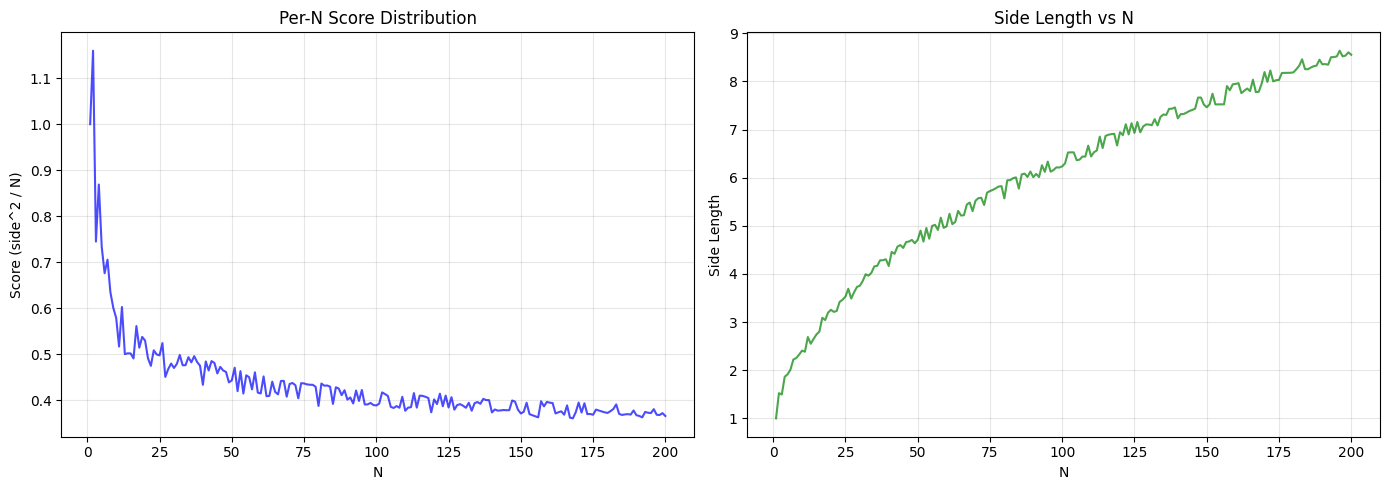

Saved to /home/code/exploration/per_n_analysis.png


In [4]:
# Plot per-N scores
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(scores_df['N'], scores_df['score'], 'b-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (side^2 / N)')
plt.title('Per-N Score Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(scores_df['N'], scores_df['side'], 'g-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Side Length')
plt.title('Side Length vs N')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()
print('Saved to /home/code/exploration/per_n_analysis.png')

In [5]:
# Analyze which N values contribute most to total score
scores_df['contribution'] = scores_df['score'] / scores_df['score'].sum() * 100
print('Top 10 N values by contribution to total score:')
print(scores_df.nlargest(10, 'contribution')[['N', 'score', 'contribution']])

Top 10 N values by contribution to total score:
     N     score  contribution
1    2  1.159640      1.336028
0    1  1.000000      1.152105
3    4  0.868829      1.000982
2    3  0.744906      0.858211
4    5  0.733394      0.844947
6    7  0.705515      0.812827
5    6  0.676163      0.779011
7    8  0.634881      0.731449
11  12  0.602703      0.694377
8    9  0.600971      0.692382


In [6]:
# Calculate theoretical minimum for each N
# For a single tree: side = 1.0 (height), score = 1.0
# For N trees in perfect packing: side ~ sqrt(N * tree_area)
# Tree area ~ 0.35 (approximate)

tree_area = 0.35  # approximate
scores_df['theoretical_min'] = (np.sqrt(scores_df['N'] * tree_area) ** 2) / scores_df['N']
scores_df['gap_to_theoretical'] = scores_df['score'] - scores_df['theoretical_min']

print('N values with largest gap to theoretical minimum:')
print(scores_df.nlargest(10, 'gap_to_theoretical')[['N', 'score', 'theoretical_min', 'gap_to_theoretical']])

N values with largest gap to theoretical minimum:
     N     score  theoretical_min  gap_to_theoretical
1    2  1.159640             0.35            0.809640
0    1  1.000000             0.35            0.650000
3    4  0.868829             0.35            0.518829
2    3  0.744906             0.35            0.394906
4    5  0.733394             0.35            0.383394
6    7  0.705515             0.35            0.355515
5    6  0.676163             0.35            0.326163
7    8  0.634881             0.35            0.284881
11  12  0.602703             0.35            0.252703
8    9  0.600971             0.35            0.250971


In [7]:
# Check if eazy optimizer is ready
import subprocess
result = subprocess.run(['ls', '-la', '/home/code/eazy'], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

-rwxr-xr-x 1 nonroot nonroot 73840 Jan 20 03:43 /home/code/eazy


